<a href="https://colab.research.google.com/github/ShubhamGupta19/CnnBasedAndroidapp_plant_species_detection/blob/master/FinalPlantsModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from tensorflow.keras.callbacks import BaseLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from  tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Input
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import h5py       
import cv2
import imutils
import glob

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
train_dir ='/content/drive/My Drive/PlantsProject/output/train'
test_dir='/content/drive/My Drive/PlantsProject/output/val'

In [43]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [44]:


train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")


100 Classes
1200 Train images
400 Test images


In [45]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [46]:

# set height and width and color of input image.
img_width,img_height =256,256
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(img_width,img_height), batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(img_width,img_height),batch_size=batch_size)


Found 1200 images belonging to 100 classes.
Found 400 images belonging to 100 classes.


In [47]:
train_generator.class_indices

{'Acer_Campestre': 0,
 'Acer_Capillipes': 1,
 'Acer_Circinatum': 2,
 'Acer_Mono': 3,
 'Acer_Opalus': 4,
 'Acer_Palmatum': 5,
 'Acer_Pictum': 6,
 'Acer_Platanoids': 7,
 'Acer_Rubrum': 8,
 'Acer_Rufinerve': 9,
 'Acer_Saccharinum': 10,
 'Alnus_Cordata': 11,
 'Alnus_Maximowiczii': 12,
 'Alnus_Rubra': 13,
 'Alnus_Sieboldiana': 14,
 'Alnus_Viridis': 15,
 'Arundinaria_Simonii': 16,
 'Betula_Austrosinensis': 17,
 'Betula_Pendula': 18,
 'Callicarpa_Bodinieri': 19,
 'Castanea_Sativa': 20,
 'Celtis_Koraiensis': 21,
 'Cercis_Siliquastrum': 22,
 'Cornus_Chinensis': 23,
 'Cornus_Controversa': 24,
 'Cornus_Macrophylla': 25,
 'Cotinus_Coggygria': 26,
 'Crataegus_Monogyna': 27,
 'Cytisus_Battandieri': 28,
 'Eucalyptus_Glaucescens': 29,
 'Eucalyptus_Neglecta': 30,
 'Eucalyptus_Urnigera': 31,
 'Fagus_Sylvatica': 32,
 'Ginkgo_Biloba': 33,
 'Ilex_Aquifolium': 34,
 'Ilex_Cornuta': 35,
 'Liquidambar_Styraciflua': 36,
 'Liriodendron_Tulipifera': 37,
 'Lithocarpus_Cleistocarpus': 38,
 'Lithocarpus_Edulis': 39,

In [48]:
class MiniGoogLeNet:
  @staticmethod
  def conv_module(x,K,kX,kY,stride,chanDim,padding="same"):
    x=Conv2D(K,(kX,kY),strides=stride,padding=padding)(x)
    x=BatchNormalization(axis=chanDim)(x)
    x=Activation("relu")(x)
    return x

  @staticmethod
  def inception_module(x,numK1x1,numK3x3,chanDim):
    conv_1x1=MiniGoogLeNet.conv_module(x,numK1x1,1,1,(1,1),chanDim)
    conv_3x3=MiniGoogLeNet.conv_module(x,numK3x3,3,3,(1,1),chanDim)
    x=concatenate([conv_1x1,conv_3x3],axis=chanDim)
    return x

  @staticmethod 
  def downsample_module(x,K,chanDim):
    conv_3x3=MiniGoogLeNet.conv_module(x,K,3,3,(2,2),chanDim,padding="valid")
    pool=MaxPooling2D((3,3),strides=(2,2))(x)
    x=concatenate([conv_3x3,pool],axis=chanDim)
    return x
  
  def build(width,height,depth,classes):
    inputShape=(height,width,depth)
    chanDim=-1
    if K.image_data_format()=="channels_first":
      inputShape=(depth,height,width)
      chanDim= 1
    inputs=Input(shape=inputShape)
    x=MiniGoogLeNet.conv_module(inputs,96,3,3,(1,1),chanDim)
    x=MiniGoogLeNet.inception_module(x,32,32,chanDim)
    x=MiniGoogLeNet.downsample_module(x,80,chanDim)
    x=MiniGoogLeNet.inception_module(x,112,48,chanDim)
    x=MiniGoogLeNet.inception_module(x,96,64,chanDim)
    x=MiniGoogLeNet.inception_module(x,80,80,chanDim)
    x=MiniGoogLeNet.inception_module(x,48,96,chanDim)
    x=MiniGoogLeNet.downsample_module(x,96,chanDim)
    x=MiniGoogLeNet.inception_module(x,176,160,chanDim)
    x=MiniGoogLeNet.inception_module(x,176,160,chanDim)
    x=AveragePooling2D((7,7))(x)
    x=Dropout(0.5)(x)

    x=Flatten()(x)
    x=Dense(classes)(x)
    x=Activation("softmax")(x)

    model=Model(inputs,x,name="googlenet")
    return model


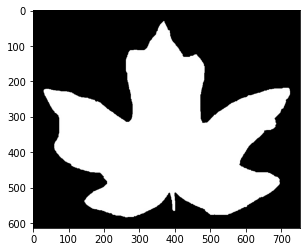

In [49]:

from keras.preprocessing import image
import numpy as np
img1 = image.load_img('/content/drive/My Drive/PlantsProject/output/train/Acer_Campestre/Acer_Campestre_01.ab.jpg')
plt.imshow(img1);
#preprocess image
img1 = image.load_img('/content/drive/My Drive/PlantsProject/output/train/Acer_Campestre/Acer_Campestre_02.ab.jpg', target_size=(256, 256))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)


In [ ]:
aug=ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest"
        )

In [50]:
NUM_EPOCHS=70
INIT_LR=5e-3

In [39]:
print("[INFO] Compiling model")
opt=SGD(lr=INIT_LR,momentum=0.9)
model=MiniGoogLeNet.build(width=256,height=256,depth=3,classes=num_classes)
model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=['accuracy'])


[INFO] Compiling model


In [56]:
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 96) 2688        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 96) 384         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 96) 0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [39]:
model.fit(aug.flow(trainX,trainY,batch_size=64), validation_data=(testX,testY),steps_per_epoch=len(trainX)//64, epochs=NUM_EPOCHS,callbacks=callbacks,verbose=1)

In [54]:
train=model.fit_generator(train_generator,epochs=100,steps_per_epoch=train_generator.samples//batch_size,validation_data=test_generator,validation_steps=test_generator.samples // batch_size,verbose=1)

Epoch 1/100
37/37 [==============================] - 367s 10s/step - loss: 5.0708 - accuracy: 0.0354 - val_loss: 4.6053 - val_accuracy: 0.0260
Epoch 2/100
37/37 [==============================] - 43s 1s/step - loss: 4.1325 - accuracy: 0.1446 - val_loss: 4.6769 - val_accuracy: 0.0208
Epoch 3/100
37/37 [==============================] - 43s 1s/step - loss: 3.3774 - accuracy: 0.2249 - val_loss: 4.6656 - val_accuracy: 0.0260
Epoch 4/100
37/37 [==============================] - 43s 1s/step - loss: 2.7572 - accuracy: 0.3262 - val_loss: 4.4632 - val_accuracy: 0.0234
Epoch 5/100
37/37 [==============================] - 43s 1s/step - loss: 2.5954 - accuracy: 0.3733 - val_loss: 4.0596 - val_accuracy: 0.0677
Epoch 6/100
37/37 [==============================] - 43s 1s/step - loss: 2.3392 - accuracy: 0.4373 - val_loss: 4.1230 - val_accuracy: 0.0521
Epoch 7/100
37/37 [==============================] - 43s 1s/step - loss: 2.1504 - accuracy: 0.4664 - val_loss: 3.3865 - val_accuracy: 0.2083
Epoch 8/100

In [55]:
print("[INFO] Serializing Network")
model.save(r"/content/drive/My Drive/minigooglenet_plants.h5")

[INFO] Serializing Network
